<a href="https://colab.research.google.com/github/SwapnilSParkhe/Machine-Learning/blob/master/2c_Hyper_parameter_Tuning_and_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection using Anomaly Detection | Part 2c (Tuning)

**Summary:**
Using "semi-supervised" approach of anomaly detection to train and tune models. How:
- Training model on only "normal" observations
- Tuning or validation using a set of observations that contains "normal" and "anomalous" both 
- Eventually, test on observations which were held-out before training and tuning
- Using "f1" (alongside other metrics like PR-AUC, Recall, etc.) to judge
- Flow:
  - Build baseline models with default settings
  - Understand the bias-variance tradeoffs through debugging curves
  - Train and tune using RSCV, GSCV to find best model


**Pros/Cons:**
- We could use gridsearchcv indirectly. We'll create custom CV folds s.t. training and tuning happens as per "semi-supervised" expectation
- We are assuming that the anomaly rate in training/tuning data will match to that in the future data


## 1. Importing Libraries

In [1]:
#Importing necessary data science libraries
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt; 
%matplotlib inline
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
import pickle
import scipy.stats as stats

#Importing data processing and prep libraries
from sklearn.preprocessing import StandardScaler, RobustScaler   #RobustScaler robust to outliers
from sklearn.model_selection import train_test_split, StratifiedKFold #for custom data splits
from sklearn.model_selection import learning_curve, validation_curve #for preliminary diagnosis/bias-variance checks
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  #for hyperparameter tuning

#Importing machine learning algo libraries
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

#Importing evaluation focussed libraries
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import f1_score, recall_score, average_precision_score, make_scorer

#Other useful libraries
#!pip install missingno   
import missingno as missviz   #Custom library for missing value inspections
from sklearn.manifold import TSNE   #For visualising high dimensional data

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Getting relevant data

**2.1 Google colab integration stuff**

In [ ]:
#Mounting my google drive in colab env
from google.colab import drive
drive.mount('/content/drive')

In [5]:
#Checking contents (to figure out folder in the drive, where I uploaded my data)
!ls '/content/drive/My Drive/Colab Notebooks/'

'Copy of FASTAI-Lesson2.ipynb'	 FASTAI-Lesson2.ipynb
 Developing_Model.ipynb		 Projects
'FASTAI-Lesson2 (1).ipynb'	 Testing_Model.ipynb


In [6]:
#Setting our working directory as this, and chekcing contents again
%cd '/content/drive/My Drive/Colab Notebooks/Projects/Credit Card Fraud Detection'
!ls
  

/content/drive/My Drive/Colab Notebooks/Projects/Credit Card Fraud Detection
'2c. Hyper-parameter Tuning and Model Selection.ipynb'	 ADS_a.pkl


**2.2 Importing the data now, fromt he colab directory**

In [7]:
#Importing
with open("ADS_a.pkl", "rb") as f:
    X_in, y_in, X_in_out, y_in_out, X_cols, y_cols = pickle.load(f)
    
#Basic details
print("Details of inliers data - shape of predictor matrix is {I} and # ones in target series is {J}".format(I=X_in.shape, J=sum(y_in)))
print("Details of inliers_outliers data - shape of predictor matrix is {I} and # ones in target series is {J}".format(I=X_in_out.shape, J=sum(y_in_out)))

Details of inliers data - shape of predictor matrix is (227452, 30) and # ones in target series is 0
Details of inliers_outliers data - shape of predictor matrix is (57355, 30) and # ones in target series is 492


## 3. Drafting model

**3.1 Building basline model (default settings)**

In [8]:
#Creating a class of basic anomaly detections (or "BAD")
class Basic_Anomaly_Detectors:
    """
    Accepts {models} that should run on data
    """
    def __init__(self, models):
        self.models = models
       
    def provide_data(self, X_in, X_in_out, y_in, y_in_out): 
        #Training will have inliers only; Test will have a separate subset of inliers & outliers  
        self.X_train = X_in
        self.y_train = y_in
        self.X_test = X_in_out
        self.y_test = y_in_out
        
        #Print basic details
        print("Details of train data - shape of predictor matrix is {I} and # ones in target series is {J}".format(I=self.X_train.shape, J=sum(self.y_train)))
        print("Details of test data - shape of predictor matrix is {I} and # ones in target series is {J}".format(I=self.X_test.shape, J=sum(self.y_test)))
    
    def fit_score_predict(self):
        y_scores_dict={}
        y_pred_dict={}
        results=[] 
        for model_name, model in self.models.items():
            print("------------------Fitting {M} algorithm---------------".format(M=model_name))
            
            %time model.fit(self.X_train)
            y_scores = model.decision_function(self.X_test)
            y_pred = model.predict(self.X_test)
                 
            #The algos predicts {1,-1} for {normal, anomalous} case, whereas original y has {0,1}
            y_pred[y_pred==1]=0
            y_pred[y_pred==-1]=1

            #Evaluation (using Recall, F1, PR-AUC)
            Recall = recall_score(self.y_test,y_pred)
            F1= f1_score(self.y_test,y_pred)
            PR_AUC = average_precision_score(self.y_test,y_scores)

            #Collating outputs
            y_scores_dict[model_name]=y_scores
            y_pred_dict[model_name]=y_pred
            results.append([model_name, Recall, F1, PR_AUC])
        
        self.y_scores_dict=y_scores_dict
        self.y_pred_dict=y_pred_dict
        self.results_df = pd.DataFrame(results, columns=["model_name", "Recall", "F1", "PR_AUC"])
        
    def evaluate_plot(self):
        for model_name, model in self.models.items():
            print("------------------Evaluating/Plotting {M} algorithm------------------".format(M=model_name))
            results_df_model = self.results_df[self.results_df["model_name"]==model_name]

            #Printing results
            print('Classifiation report on test data:', '\n', classification_report(self.y_test,self.y_pred_dict[model_name]))  
            print('Recall: {}'.format(results_df_model["Recall"].values))
            print('F1: {}'.format(results_df_model["F1"].values))
            print("PR-AUC: {}".format(results_df_model["PR_AUC"].values))    

            #Plotting results
            cm=confusion_matrix(self.y_test,self.y_pred_dict[model_name])
            P, R, _ = precision_recall_curve(self.y_test,self.y_scores_dict[model_name])

            fig, axs = plt.subplots(1,2, figsize=(16,5))
            axs=axs.flatten()

            sns.heatmap(cm, annot=True, ax=axs[0], fmt=".1f")
            axs[0].set_xlabel("Predicted"); axs[0].xaxis.set_ticklabels(['normal', 'anomaly'])
            axs[0].set_ylabel("Actual"); axs[0].yaxis.set_ticklabels(['normal', 'anomaly'])
            axs[0].set_title("Confusion Matrix")

            axs[1].plot(P,R)
            axs[1].set_xlabel('Recall')
            axs[1].set_ylabel('Precision')
            axs[1].set_title("PR-curve")

            plt.show()
            fig.tight_layout()

In [9]:
#Creating a dictionary of models (anomaly detectors in "novel" detection mode)
seed=123
models = {
    "IF": IsolationForest(random_state=seed),
    "LOF": LocalOutlierFactor(novelty=True),
    "OCSVM": OneClassSVM()}

Details of train data - shape of predictor matrix is (227452, 30) and # ones in target series is 0
Details of test data - shape of predictor matrix is (57355, 30) and # ones in target series is 492
------------------Fitting IF algorithm---------------
CPU times: user 10.1 s, sys: 3.55 s, total: 13.6 s
Wall time: 14 s
------------------Fitting LOF algorithm---------------
CPU times: user 14min 35s, sys: 12.7 s, total: 14min 47s
Wall time: 15min 5s
------------------Fitting OCSVM algorithm---------------
CPU times: user 1h 52s, sys: 2min 13s, total: 1h 3min 6s
Wall time: 1h 4min 49s
------------------Evaluating/Plotting IF algorithm------------------
Classifiation report on test data: 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     56863
           1       0.07      0.88      0.13       492

   micro avg       0.90      0.90      0.90     57355
   macro avg       0.53      0.89      0.54     57355
weighted avg       0.99      0.90 

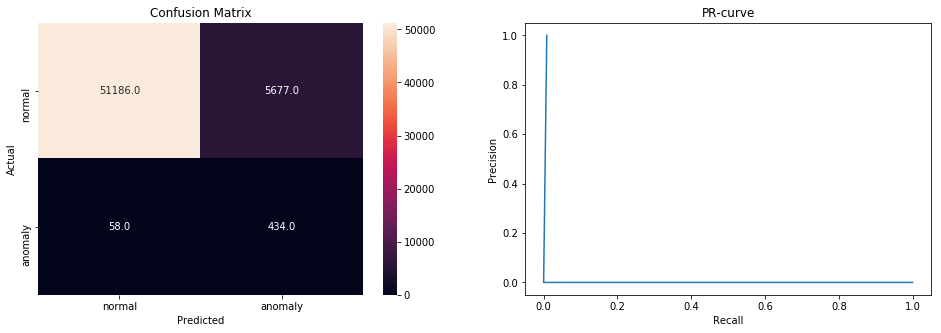

------------------Evaluating/Plotting LOF algorithm------------------
Classifiation report on test data: 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     56863
           1       0.03      0.32      0.05       492

   micro avg       0.90      0.90      0.90     57355
   macro avg       0.51      0.61      0.50     57355
weighted avg       0.99      0.90      0.94     57355

Recall: [0.32317073]
F1: [0.05019732]
PR-AUC: [0.00545146]


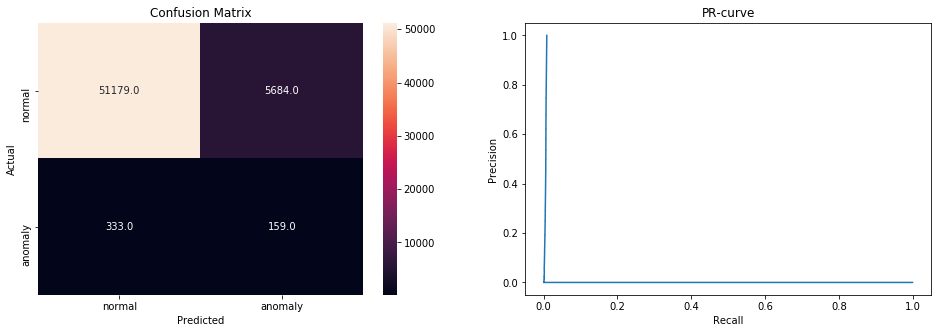

------------------Evaluating/Plotting OCSVM algorithm------------------
Classifiation report on test data: 
               precision    recall  f1-score   support

           0       1.00      0.50      0.67     56863
           1       0.02      0.97      0.03       492

   micro avg       0.50      0.50      0.50     57355
   macro avg       0.51      0.73      0.35     57355
weighted avg       0.99      0.50      0.66     57355

Recall: [0.96747967]
F1: [0.03236004]
PR-AUC: [0.00435116]


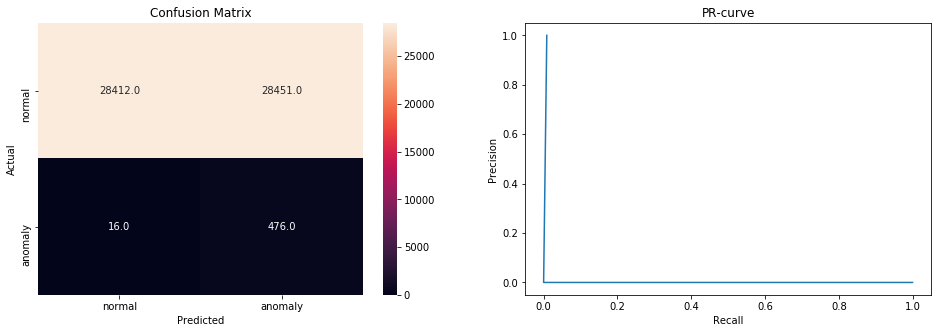

In [ ]:
#Instantiating and running our "Basic_Anomaly_Detectors"
BAD=Basic_Anomaly_Detectors(models)
BAD.provide_data(X_in, X_in_out, y_in, y_in_out)
BAD.fit_score_predict()
BAD.evaluate_plot()

In [ ]:
#Result summary of "Basic_Anomaly_Detectors"
BAD.results_df

,model_name,Recall,F1,PR_AUC
0,IF,0.882114,0.131455,0.004364
1,LOF,0.323171,0.050197,0.005451
2,OCSVM,0.967480,0.032360,0.004351


**3.2 Preliminary Dignostic plots to check bias-variance tradeoffs**
- **Learning curve**: To check how amount of training data affects model performance. How to use:
    - Check where do training & validation scores start coverging => This much amount of training data should be good enough to stabilise our models
    - Check if the converged training score is significantly lower (as compared to validation score or expectations) => If yes, then we might need to increases the model complexity
- **Validation curve**: To check behavior of a single hyperparameter w.r.t  model performance
    - Check the tipping point where the training and validation scores are good and then start diverging => Before this tipping pount, it's generally the case of underfitting and above it's overfitting
    

In [11]:
#Creating a dictionary of models (anomaly detectors in "novel" detection mode)
seed=123
models = {
    "IF": IsolationForest(random_state=seed),
    "LOF": LocalOutlierFactor(novelty=True),
    "OCSVM": OneClassSVM()}

#Creating a dictionary of models's hyperparameters and their ranges
models_hps_ranges={
    "IF": {"contamination": [0.0001, 0.001, 0.0025, 0.005, 0.01], "max_samples": list(range(100,20000,4000)), "n_estimators": [10,50,100,200,500]},
    "LOF": {"contamination": [0.0001, 0.001, 0.0025, 0.005, 0.01], "n_neighbors": [5,10,20,50,100]},
    "OCSVM": {"nu": [0.0001, 0.001, 0.0025, 0.005, 0.01], "kernel": ["linear", "rbf", "poly"], "gamma": np.power(10.0, range(-3,2))}}

#Creating a custom scoring function to pass to scorer for VC and LC (which takes in 2 arguments - y_true, y_pred)
def custom_f1_score_func(y_true, y_pred):
    f1=f1_score(y_true, np.where(y_pred==1,0,1))
    return f1
custom_f1_score = make_scorer(custom_f1_score_func, greater_is_better=True)

In [12]:
#Creating a class for preliminary diagonosis curves for our basic anomaly detectors (and their hps)
class BAD_diagnosis():
    """
    Return learning and validation curves for {models} and their {models_hps_ranges}; 
    By passing inliers and outliers data based on scoring 
    Note: 
        - Since, this is preliminrary diagnosis, we are using the "supervised" setting for these plots to check training and validation perforamnces. 
        - If we use the intended "semi-supervised" setting, we'll always get training score ("f1" here as 0) as its only inliers data
    Abbrevations:
        - LC is learning curve which is going to be run on whole data (we decide the train_sizes, hence no argument for that)
        - VC is validation curve which is going to be run on 5% of data  (we're passing stratifiedkfolds for the CV)
    """
    def __init__(self, models, models_hps_ranges, seed=1):
        self.models=models
        self.models_hps_ranges=models_hps_ranges
        self.seed=seed
        
    def provide_data(self, X_in, y_in, X_in_out, y_in_out):
        self.X_in=X_in
        self.y_in=y_in
        self.X_in_out=X_in_out
        self.y_in_out=y_in_out
        
        #Combining data of inliers + (inliers+outliers) to pass to sklearn's learning_curve
        self.X_comb = np.concatenate((X_in, X_in_out), axis=0)
        self.y_comb = np.concatenate((y_in, y_in_out), axis=0)
        print("Anomaly fraction in original data = {}".format(self.y_comb.sum()/len(self.y_comb)))

    def plot_LC(self, scoring, n_folds=3):
        print("----------------------\n Learning Curves \n----------------------")
        
        fig, axs = plt.subplots(1,3, figsize=(16,4))
        axs = axs.flatten()
        for i, (modelname, model) in enumerate(self.models.items()):
            print("-----Running {}-----".format(modelname))
            model = model
            train_sizes_list = np.linspace(0.1, 1.0, 5)
            
            train_sizes, train_scores, valid_scores = learning_curve(model, self.X_comb, self.y_comb,
                                                                     train_sizes=train_sizes_list, 
                                                                     scoring=scoring, cv=StratifiedKFold(n_folds, random_state=self.seed),
                                                                     verbose=10, n_jobs=-1)
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            valid_scores_mean = np.mean(valid_scores, axis=1)
            valid_scores_std = np.std(valid_scores, axis=1)

            #Plotting
            axs[i].plot(train_sizes,train_scores_mean, color='red')
            axs[i].plot(train_sizes,valid_scores_mean, color='green')
            axs[i].fill_between(train_sizes,valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='green', alpha=0.1)
            axs[i].set_title(modelname)
            axs[i].set_xlabel("train_sizes")
            axs[i].set_ylabel("f1")
                
        plt.show()
        plt.tight_layout()
        
        
    def prep_data_for_VC(self):
        X_in_big, X_in_small, y_in_big, y_in_small = train_test_split(self.X_in, self.y_in, test_size=0.05, random_state=self.seed)
        X_in_out_big, X_in_out_small, y_in_out_big, y_in_out_small = train_test_split(self.X_in_out, self.y_in_out, test_size=0.05, stratify=np.array(self.y_in_out), random_state=self.seed)

        #Combining "small" data of inliers + (inliers+outliers) to pass to sklearn's validation_curve
        self.X_comb_small = np.concatenate((X_in_small, X_in_out_small), axis=0)
        self.y_comb_small = np.concatenate((y_in_small, y_in_out_small), axis=0)
        print("Anomaly fraction in the small subset = {}".format(self.y_comb_small.sum()/len(self.y_comb_small)))
        
    def plot_VC(self, scoring, n_folds):
        print("----------------------\n Validation Curves \n----------------------")
        
        for modelname, model in self.models.items():
            print("-----Running {}-----".format(modelname))
            model = model
            model_hps_ranges = self.models_hps_ranges[modelname]
            
            fig, axs = plt.subplots(1,3, figsize=(16,4))
            axs = axs.flatten()
            for i, (hpname, hprange) in enumerate(model_hps_ranges.items()):
                print("Passing hyperparameter, {HP}, which takes these values {HPV} iteratively".format(HP=hpname, HPV=hprange))
                train_scores, valid_scores = validation_curve(model, self.X_comb_small, self.y_comb_small,
                                                              hpname, hprange,
                                                              scoring=scoring, cv=StratifiedKFold(n_folds, random_state=self.seed),
                                                              verbose=10, n_jobs=-1)                                   
                train_scores_mean = np.mean(train_scores, axis=1)
                train_scores_std = np.std(train_scores, axis=1)
                valid_scores_mean = np.mean(valid_scores, axis=1)
                valid_scores_std = np.std(valid_scores, axis=1)
                
                #Plotting
                axs[i].plot(hprange,train_scores_mean, color='red')
                axs[i].plot(hprange,valid_scores_mean, color='green')
                axs[i].fill_between(hprange,valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='green', alpha=0.1)
                axs[i].set_xlabel(hpname)
                axs[i].set_ylabel("f1")
                
            plt.show()
            plt.tight_layout()
        

In [13]:
#Instantiating and doing necessary things for our "Preliminary_diagnosis" for BADs
PD = BAD_diagnosis(models, models_hps_ranges, seed)
PD.provide_data(X_in, y_in, X_in_out, y_in_out)
PD.prep_data_for_VC()

Anomaly fraction in original data = 0.001727485630620034
Anomaly fraction in the small subset = 0.0017554946984060108


----------------------
 Learning Curves 
----------------------
-----Running IF-----
[learning_curve] Training set sizes: [ 18987  61708 104429 147150 189871]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    9.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   24.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   38.6s remaining:   57.9s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   51.1s remaining:   44.7s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  1.0min remaining:   30.7s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.2min remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-----Running LOF-----
[learning_curve] Training set sizes: [ 18987  61708 104429 147150 189871]


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed: 12.9min remaining: 83.8min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed: 51.5min remaining: 141.5min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 68.6min remaining: 102.8min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 96.8min remaining: 84.7min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 131.0min remaining: 65.5min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 157.8min remaining: 39.4min


-----Running OCSVM-----
[learning_curve] Training set sizes: [ 18987  61708 104429 147150 189871]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 228.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed: 15.1min remaining: 97.9min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed: 89.7min remaining: 246.6min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 108.0min remaining: 162.0min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 163.0min remaining: 142.7min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 223.8min remaining: 111.9min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 277.6min remaining: 69.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 386.7min finished


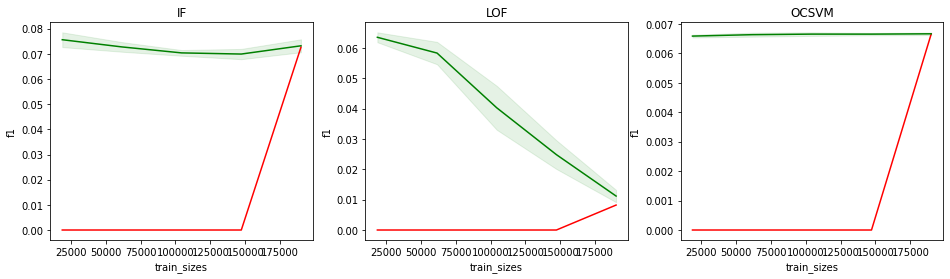

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting LC 
#Seems like using whole data is gonna be more useful rather than a small chunk; we'll use full data on Google colab 
#Also, seems like IF and OCSVM get better as train size increases, whereas LOF doesn't seem to perform well! 
PD.plot_LC(custom_f1_score, 3)

----------------------
 Validation Curves 
----------------------
-----Running IF-----
Passing hyperparameter, contamination, which takes these values [0.0001, 0.001, 0.0025, 0.005, 0.01] iteratively


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    3.7s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    6.2s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    8.6s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   11.0s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   13.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   15.9s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Passing hyperparameter, max_samples, which takes these values [10, 2010, 4010, 6010, 8010] iteratively


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    1.8s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    3.9s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    7.3s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    9.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   11.3s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Passing hyperparameter, n_estimators, which takes these values [10, 50, 100, 200, 500] iteratively


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    0.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    4.2s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    5.2s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    9.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   10.4s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   13.1s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   22.0s finished


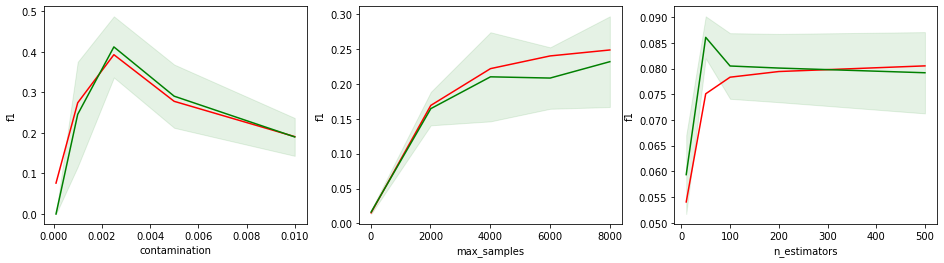

-----Running LOF-----
Passing hyperparameter, contamination, which takes these values [0.0001, 0.001, 0.0025, 0.005, 0.01] iteratively


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   22.1s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   43.8s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  1.9min remaining:   55.5s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.2min remaining:   33.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Passing hyperparameter, n_neighbors, which takes these values [5, 10, 20, 50, 100] iteratively


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   19.6s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   45.5s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.0min remaining:   59.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.3min remaining:   34.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.9min finished


<Figure size 432x288 with 0 Axes>

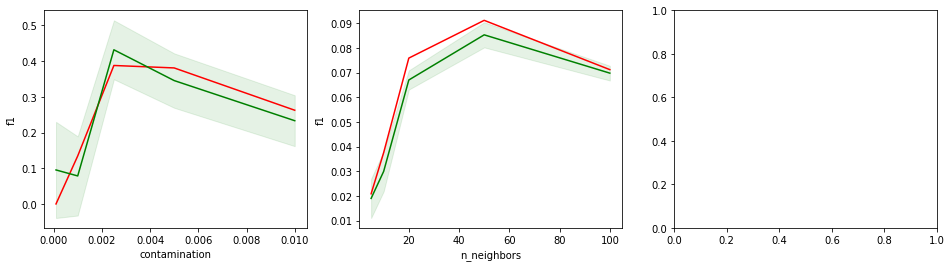

-----Running OCSVM-----
Passing hyperparameter, nu, which takes these values [0.0001, 0.001, 0.0025, 0.005, 0.01] iteratively


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    0.7s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    1.5s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    3.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    4.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Passing hyperparameter, kernel, which takes these values ['linear', 'rbf', 'poly'] iteratively


[Parallel(n_jobs=-1)]: Done   1 out of   9 | elapsed:    8.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   14.0s remaining:   48.9s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   18.2s remaining:   36.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   22.2s remaining:   27.8s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   31.6s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   32.0s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   40.3s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   48.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   48.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Passing hyperparameter, gamma, which takes these values [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] iteratively


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   13.8s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   51.5s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.4min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.4min remaining:   35.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.1min finished


<Figure size 432x288 with 0 Axes>

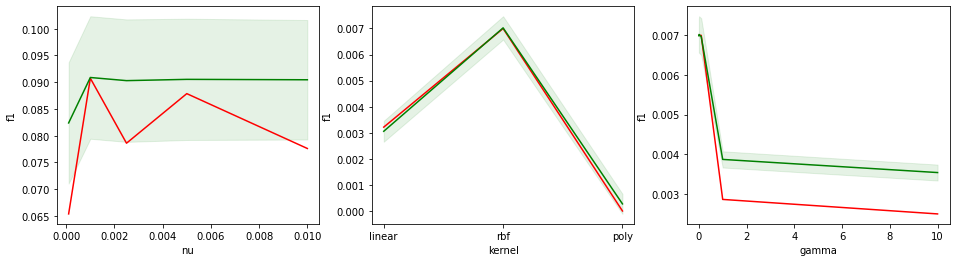

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting VC
PD.plot_VC(custom_f1_score, 3)

## 4. Hyperparameter tuning and model selection##
    a. Using small chunk of data - locally
    b. Using all available data - Google colab with TPUs

**4.a.1 Splitting data into "small" and "big" parts; and combining "small" data into one X, y**

In [14]:
#Splitting inlier and (inlier+outlier) into "small" and "big" parts to expedite training and tuning
seed=123
small_frac=0.05
X_in_big, X_in_small, y_in_big, y_in_small = train_test_split(X_in, y_in, test_size=small_frac, random_state=seed)
X_in_out_big, X_in_out_small, y_in_out_big, y_in_out_small = train_test_split(X_in_out, y_in_out, test_size=small_frac, stratify=np.array(y_in_out), random_state=seed)

In [15]:
#Making one combined data of inliers + (inliers+outliers) to be passed to next steps
X_comb_small = np.concatenate((X_in_small, X_in_out_small), axis=0)
y_comb_small = np.concatenate((y_in_small, y_in_out_small), axis=0)

**4.a.2 Creating custom CV-folds class to control how training & tuning happens**
- We need to pass CV-folds to the hyperparamter tuning algos (RSCV, GSCV) such that: 
    1. training happens only on inliers
    2. validation happens on (inliers + outliers) 

In [23]:
#Creating custom k-folds class of this combined data for tuning further such that:
class InlierOutlier_CustomCVFolds:
    def __init__(self, n_splits, random_state):
        self.n_splits=n_splits
        self.random_state = random_state
        
    def custom_split(self, X, y, groups=None):
        #Splitting X, y in KFold manner s.t. we have inliers for training and (inliers + all outliers) for validation
        for io_t_id, io_v_id in StratifiedKFold(n_splits=self.n_splits, random_state=self.random_state).split(X, y):
            y_df = pd.DataFrame(y, columns=[y_cols])

            #Segregating training_ids into inlier_training_ids and outlier_training_ids 
            temp=pd.DataFrame(y_df.iloc[io_t_id,0]==1)
            i_t_id = np.array(temp.index[temp["Class"]==False])
            o_t_id = np.array(temp.index[temp["Class"]==True])

            #Manipulating such that t_id is just inliers, whereas v_id is inliers + outliers
            t_id = i_t_id
            v_id = np.concatenate((o_t_id, io_v_id))

            yield t_id, v_id 
            
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

**4.a.3 Creating dictionary of "intialized" models and a custom scoring function for CVs**
- Note: that we need this custom scoring function for CV steps, since output of anomaly detection model prediction is {-1,1}, so in order to use f1_score appropriately, we'll need to make this transformation in predicted values of y, else it behaves weirdly

In [24]:
#Creating a dictionary of "initialized" defualt models
models={
    "IF": IsolationForest(random_state=seed),
    "LOF": LocalOutlierFactor(novelty=True),
    "OCSVM": OneClassSVM()}

#Creating a custom scoring function (which takes in 3 arguments - model, X, y under RSCV & GSCV)
def custom_f1_score_func(y_true, y_pred):
    f1=f1_score(y_true, np.where(y_pred==1,0,1))
    return f1
custom_f1_score = make_scorer(custom_f1_score_func, greater_is_better=True)

**4.a.4 Training and tuning models**
    1. Using RandomizedSearchCV first (which is also fast) to determine an interesting hyperparameter space
    2. Then, we'll use GridSearchCV later to narrow down to the specifics (space where performance seems good)

**4.a.4.1 RandomizedSearchCV (and validation curve)**

In [27]:
#Creating a dictionary of models' hyperparameters for RSCV
model_hp_dist_rscv={
    "IF": {"contamination": [10**np.random.uniform(-1, -4) for i in np.arange(1,100)], "max_samples": [10**-1*np.random.uniform(1,10) for i in np.arange(1,100)], "n_estimators": [np.random.randint(2, 1000) for i in np.arange(1,100)]},
    "LOF": {"contamination": [10**np.random.uniform(-1, -4) for i in np.arange(1,100)], "n_neighbors": [np.random.randint(2, 1000) for i in np.arange(1,100)]},
    "OCSVM": {"nu": [10**np.random.uniform(-1, -4) for i in np.arange(1,100)] , "kernel": ["linear", "rbf", "poly"], "gamma": [10**np.random.uniform(-1, -4) for i in np.arange(1,100)]}}

results_rscv=[]
for model_name in models.keys():
    print("-----Running RandomizedSearchCV for {M}-----".format(M=model_name))
    model=models[model_name]
    hp=model_hp_dist_rscv[model_name]
    cv = InlierOutlier_CustomCVFolds(3, random_state=seed).custom_split(X_comb_small, y_comb_small)
    RSCV=RandomizedSearchCV(model, hp, cv=cv, n_iter=30, random_state=seed, scoring=custom_f1_score, n_jobs=-1, verbose=10)
    %time RSCV.fit(X_comb_small, y_comb_small)
    results_rscv.append([model_name, RSCV.best_params_, RSCV.best_score_, RSCV.cv_results_])
    print("Best score: {} \n".format(RSCV.best_score_))
    print("Best hyperparams: {} \n".format(RSCV.best_params_))
    
results_rscv_df=pd.DataFrame(results_rscv, columns=["model_name", "best_hp", "best_score", "CV_results"])

-----Running RandomizedSearchCV for IF-----
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.1min finished


CPU times: user 2.41 s, sys: 57.8 ms, total: 2.47 s
Wall time: 6min 11s
Best score: 0.6074074074074075 

Best hyperparams: {'n_estimators': 170, 'max_samples': 0.7316768698201082, 'contamination': 0.0014956873832797015} 

-----Running RandomizedSearchCV for LOF-----
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.7min finished


CPU times: user 11.4 s, sys: 47.8 ms, total: 11.4 s
Wall time: 11min 53s
Best score: 0.6835933026409217 

Best hyperparams: {'n_neighbors': 140, 'contamination': 0.0014136135413044808} 

-----Running RandomizedSearchCV for OCSVM-----
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.6s finished


CPU times: user 547 ms, sys: 25.1 ms, total: 572 ms
Wall time: 24.9 s
Best score: 0.42507710154768974 

Best hyperparams: {'nu': 0.00642038631873903, 'kernel': 'rbf', 'gamma': 0.000638768987765421} 



----------------------
 Validation Curves 
----------------------
< IF >
-Best score 
 0.6074074074074075
-Best hps 
 {'n_estimators': 170, 'max_samples': 0.7316768698201082, 'contamination': 0.0014956873832797015}


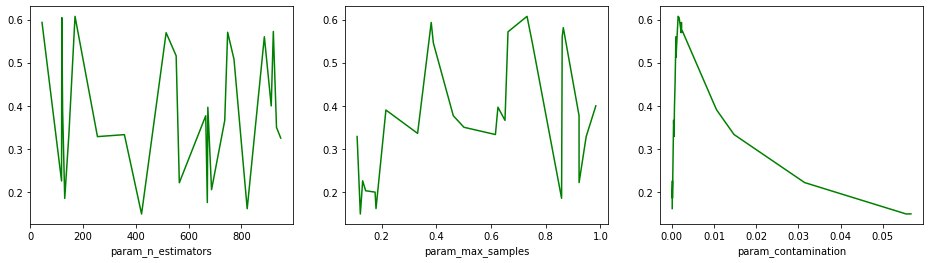

< LOF >
-Best score 
 0.6835933026409217
-Best hps 
 {'n_neighbors': 140, 'contamination': 0.0014136135413044808}


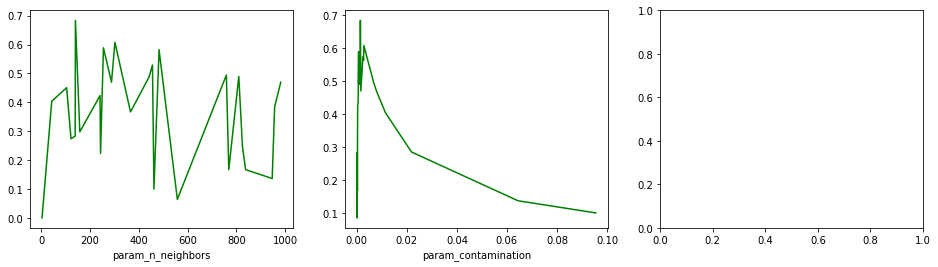

< OCSVM >
-Best score 
 0.42507710154768974
-Best hps 
 {'nu': 0.00642038631873903, 'kernel': 'rbf', 'gamma': 0.000638768987765421}


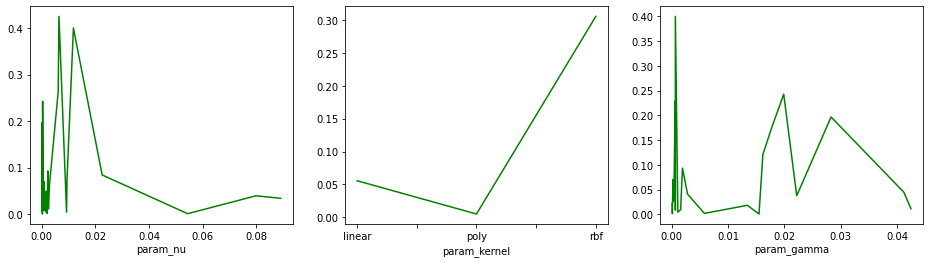

In [30]:
#Plotting validation curves:
results_model_df_dict={}
print("----------------------\n Validation Curves \n----------------------", )
for i, model_name in enumerate(models):
    print("<", model_name, ">")
    print("-Best score", "\n",results_rscv_df[results_rscv_df["model_name"]==model_name]["best_score"][i])
    print("-Best hps", "\n",results_rscv_df[results_rscv_df["model_name"]==model_name]["best_hp"][i])
    results_model_df = pd.DataFrame(results_rscv_df[results_rscv_df["model_name"]==model_name]['CV_results'].values[0])    
    hp_cols_model = [col for col in results_model_df.columns if ("param_" in col)]
    
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs=axs.flatten()
    for i, hp_col in enumerate(hp_cols_model):
        #results_model_df.sort_values(hp_col).groupby(hp_col)["mean_train_score"].mean().plot(ax=axs[i], color='red')
        results_model_df.sort_values(hp_col).groupby(hp_col)["mean_test_score"].mean().plot(ax=axs[i], color='green')
        
    plt.show()

**4.4.2 GridSearchCV**

In [35]:
model_hp_grid_gscv={
    "IF": {"contamination": [0.0010, 0.0015, 0.0020, 0.0025, 0.0030], "max_samples": [0.60, 0.65, 0.70, 0.75, 0.80], "n_estimators": [150,160,170,180,190]},
    "LOF": {"contamination": [0.0010, 0.0015, 0.0020, 0.0025, 0.0030], "n_neighbors": [130, 135, 140, 145, 150]},
    "OCSVM": {"nu": [0.004, 0.005, 0.006, 0.007, 0.008], "kernel": ["linear", "rbf", "poly"], "gamma": [0.0004, 0.00055, 0.0006, 0.00065, 0.0008]}}

results_gscv=[]
for model_name in models.keys():
    print("-----Running GridSearchCV for {M}-----".format(M=model_name))
    model=models[model_name]
    hp=model_hp_grid_gscv[model_name]
    cv = InlierOutlier_CustomCVFolds(3, random_state=seed).custom_split(X_comb_small, y_comb_small)
    GSCV=GridSearchCV(model, hp, cv=cv, scoring=custom_f1_score, n_jobs=-1, verbose=10)
    %time GSCV.fit(X_comb_small, y_comb_small)
    results_gscv.append([model_name, GSCV.best_params_, GSCV.best_score_, GSCV.cv_results_])
    print("Best score: {} \n".format(GSCV.best_score_))
    print("Best hyperparams: {} \n".format(GSCV.best_params_))
    
results_gscv_df=pd.DataFrame(results_gscv, columns=["model_name", "best_hp", "best_score", "CV_results"])

-----Running GridSearchCV for IF-----
Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  3

CPU times: user 3.63 s, sys: 181 ms, total: 3.81 s
Wall time: 8min 12s
Best score: 0.6181101798123075 

Best hyperparams: {'contamination': 0.0015, 'max_samples': 0.75, 'n_estimators': 150} 

-----Running GridSearchCV for LOF-----
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.5min finished


CPU times: user 11.6 s, sys: 35.6 ms, total: 11.7 s
Wall time: 8min 44s
Best score: 0.6930209120685312 

Best hyperparams: {'contamination': 0.0015, 'n_neighbors': 140} 

-----Running GridSearchCV for OCSVM-----
Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1824s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1760s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too slow (5.7918s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  

CPU times: user 940 ms, sys: 51.9 ms, total: 992 ms
Wall time: 47.2 s
Best score: 0.5 

Best hyperparams: {'gamma': 0.0008, 'kernel': 'rbf', 'nu': 0.004} 



----------------------
 Validation Curves 
----------------------
< IF >
-Best score 
 0.6181101798123075
-Best hps 
 {'contamination': 0.0015, 'max_samples': 0.75, 'n_estimators': 150}


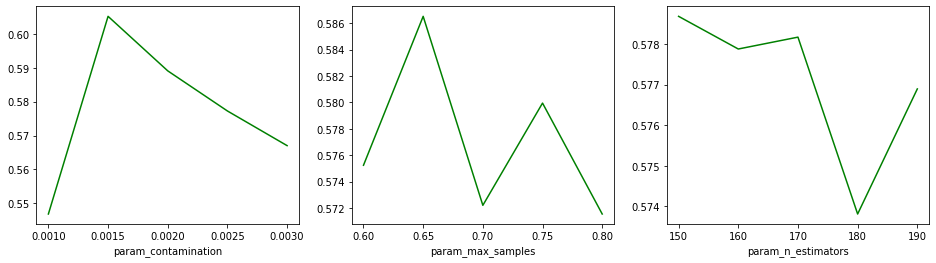

< LOF >
-Best score 
 0.6930209120685312
-Best hps 
 {'contamination': 0.0015, 'n_neighbors': 140}


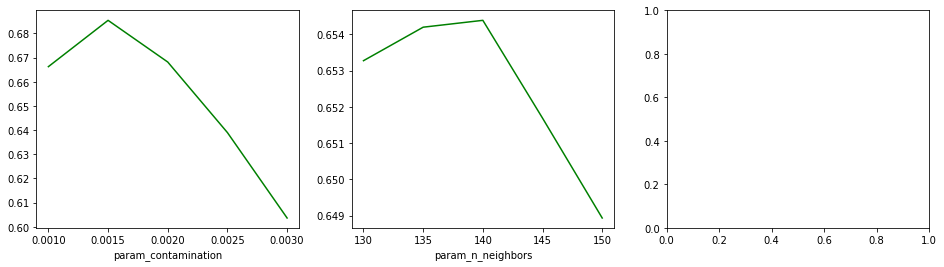

< OCSVM >
-Best score 
 0.5
-Best hps 
 {'gamma': 0.0008, 'kernel': 'rbf', 'nu': 0.004}


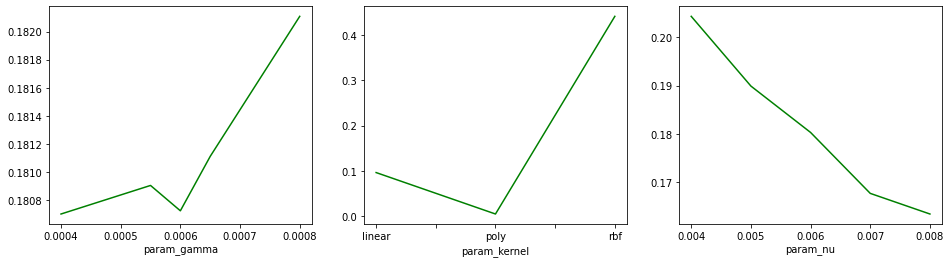

In [38]:
#Plotting validation curves:
results_model_df_dict={}
print("----------------------\n Validation Curves \n----------------------", )
for i, model_name in enumerate(models):
    print("<", model_name, ">")
    print("-Best score", "\n",results_gscv_df[results_gscv_df["model_name"]==model_name]["best_score"][i])
    print("-Best hps", "\n",results_gscv_df[results_gscv_df["model_name"]==model_name]["best_hp"][i])
    results_model_df = pd.DataFrame(results_gscv_df[results_gscv_df["model_name"]==model_name]['CV_results'].values[0])    
    hp_cols_model = [col for col in results_model_df.columns if ("param_" in col)]
    
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs=axs.flatten()
    for i, hp_col in enumerate(hp_cols_model):
        #results_model_df.sort_values(hp_col).groupby(hp_col)["mean_train_score"].mean().plot(ax=axs[i], color='red')
        results_model_df.sort_values(hp_col).groupby(hp_col)["mean_test_score"].mean().plot(ax=axs[i], color='green')
        
    plt.show()

---
#Work in progress#
---

**Creating a custom class for tuning**

In [140]:
class tuning:
  '''
  Pass tuning algo and AD models you want to run on data 
  '''
  def __init__(self, tuning_algo_name, models, models_hps_range, scoring, seed=1):
    self.tuning_algo_name=tuning_algo_name
    self.models=models
    self.models_hps_range=models_hps_range
    self.scoring=scoring
    self.seed=seed

  def provide_data(self, X, y):
    self.X=X
    self.y=y
    print("Shape of X = {X} and y = {y}".format(X=X.shape, y=y.shape))

  def run_tuning_algo(self):
    results=[]
    for model_name in self.models.keys():
        model=self.models[model_name]
        hp=self.models_hps_range[model_name]
        cv = InlierOutlier_CustomCVFolds(3, random_state=self.seed).custom_split(self.X, self.y)

        if self.tuning_algo_name=="RSCV":
          print("-----Running RandomSearchCV for {M}-----".format(M=model_name))
          tuning_algo=RandomizedSearchCV(model, hp, cv=cv, n_iter=30, random_state=self.seed, scoring=self.scoring, n_jobs=-1, verbose=10)
          %time tuning_algo.fit(self.X, self.y)

        elif self.tuning_algo_name=="GSCV":
          print("-----Running GridSearchCV for {M}-----".format(M=model_name))
          tuning_algo=GridSearchCV(model, hp, cv=cv, scoring=self.scoring, n_jobs=-1, verbose=10)
          %time tuning_algo.fit(self.X, self.y)

        else:
          print("Please provide wither of the options: (RSCV, GSCV)")
        
        results.append([self.tuning_algo_name, model_name, tuning_algo.best_params_, tuning_algo.best_score_, tuning_algo.cv_results_])
        print("Best score: {}".format(tuning_algo.best_score_))
        print("Best hyperparams: {} \n".format(tuning_algo.best_params_))
    
    self.results_df=pd.DataFrame(results, columns=["tuning_algo_name", "model_name", "best_hp", "best_score", "CV_results"])

  def plot_VC(self):
    print("----------------------\n Validation Curves \n----------------------", )

    results_model_df_dict={}
    for i, model_name in enumerate(self.models):
        print("<", model_name, ">")
        print("-Best score", "\n",self.results_df[self.results_df["model_name"]==model_name]["best_score"][i])
        print("-Best hps", "\n",self.results_df[self.results_df["model_name"]==model_name]["best_hp"][i])
        results_model_df = pd.DataFrame(self.results_df[self.results_df["model_name"]==model_name]['CV_results'].values[0])    
        hp_cols_model = [col for col in results_model_df.columns if ("param_" in col)]
        
        fig, axs = plt.subplots(1,3, figsize=(16,4))
        axs=axs.flatten()
        for i, hp_col in enumerate(hp_cols_model):
            #results_model_df.sort_values(hp_col).groupby(hp_col)["mean_train_score"].mean().plot(ax=axs[i], color='red')
            mean = results_model_df.sort_values(hp_col).groupby(hp_col)["mean_test_score"].mean().values
            std = results_model_df.sort_values(hp_col).groupby(hp_col)["mean_test_score"].std().values
            hp_x = results_model_df.sort_values(hp_col).groupby(hp_col)["mean_test_score"].std().index

            axs[i].plot(hp_x, mean)
            axs[i].fill_between(hp_x, mean-std, mean+std)
            
        plt.show()


In [143]:
t=tuning("RSCV", models, model_hp_dist_rscv, custom_f1_score, seed=123)
t.provide_data(X_comb_small, y_comb_small)
t.run_tuning_algo()

-----Running RandomSearchCV for IF-----
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   28.1s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   36.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   36.8s finished


CPU times: user 10.9 s, sys: 271 ms, total: 11.1 s
Wall time: 48 s
Best score: 0.5732212885154062
Best hyperparams: {'n_estimators': 921, 'max_samples': 0.7514926886138188, 'contamination': 0.0025179426939656332} 

-----Running RandomSearchCV for LOF-----
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   28.1s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   42.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   42.2s finished


CPU times: user 11.3 s, sys: 11.7 ms, total: 11.3 s
Wall time: 53.6 s
Best score: 0.28458251564422365
Best hyperparams: {'n_neighbors': 158, 'contamination': 0.021838346708972573} 

-----Running RandomSearchCV for OCSVM-----
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.4s finished


CPU times: user 1.44 s, sys: 4.93 ms, total: 1.44 s
Wall time: 3.88 s
Best score: 0.12075690491250264
Best hyperparams: {'nu': 0.0028803566418966436, 'kernel': 'linear', 'gamma': 0.016176604609217982} 



----------------------
 Validation Curves 
----------------------
< IF >
-Best score 
 0.5732212885154062
-Best hps 
 {'n_estimators': 921, 'max_samples': 0.7514926886138188, 'contamination': 0.0025179426939656332}


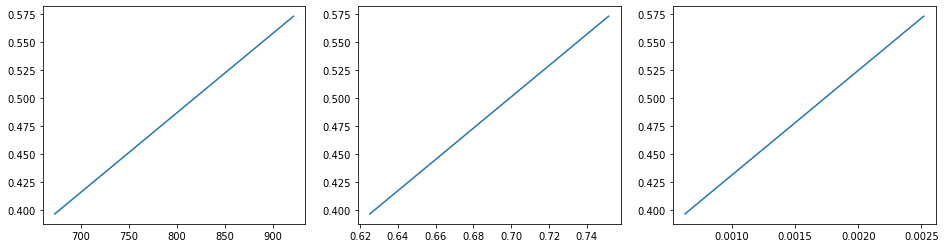

< LOF >
-Best score 
 0.28458251564422365
-Best hps 
 {'n_neighbors': 158, 'contamination': 0.021838346708972573}


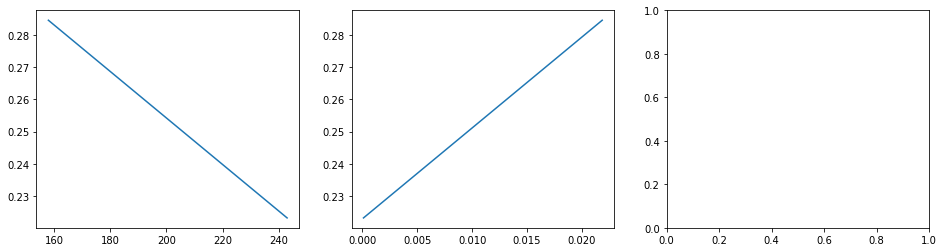

< OCSVM >
-Best score 
 0.12075690491250264
-Best hps 
 {'nu': 0.0028803566418966436, 'kernel': 'linear', 'gamma': 0.016176604609217982}


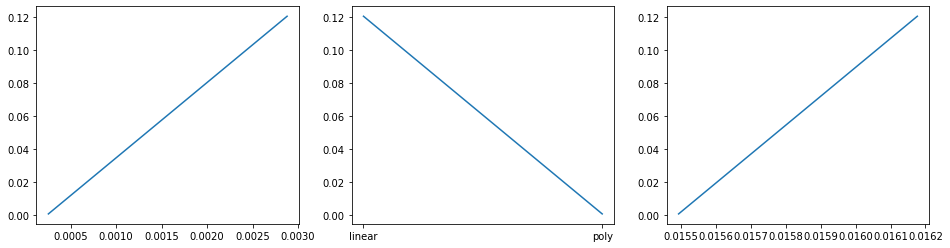

In [144]:
t.plot_VC()

In [125]:
results_model_df.sort_values(hp_col).groupby(hp_col)["mean_test_score"].mean()

param_nu
0.004    0.204321
0.005    0.189885
0.006    0.180281
0.007    0.167666
0.008    0.163395
Name: mean_test_score, dtype: float64